In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R


In [ ]:
# Spacecraft parameters
I1, I2, I3 = 100, 120, 80  # Moments of inertia (kg·m^2)
mu_mars = 4.282e13  # Mars gravitational parameter (m^3/s^2)
r = 400e3 + 3.3895e6  # Orbital radius from Mars center

def gravity_gradient_torque(q):
    """Compute gravity gradient torque in body frame based on current quaternion."""
    I = np.diag([I1, I2, I3])
    # Rotate inertial r_hat = [1, 0, 0] into body frame using quaternion
    q0, q1, q2, q3 = q
    R_matrix = np.array([
        [1 - 2*(q2**2 + q3**2),  2*(q1*q2 - q0*q3),  2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3),      1 - 2*(q1**2 + q3**2),  2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2),      2*(q2*q3 + q0*q1),  1 - 2*(q1**2 + q2**2)]
    ])
    r_hat_inertial = np.array([1.0, 0.0, 0.0])
    r_hat_body = R_matrix.T @ r_hat_inertial
    torque = 3 * mu_mars / r**3 * np.cross(I @ r_hat_body, r_hat_body)
    return torque


In [ ]:
def euler_rhs(t, state):
    """Euler's equations of motion for a rigid body with external torques."""
    omega = state[:3]
    q = state[3:]
    M = gravity_gradient_torque(q)
    omega_dot = np.array([
        (M[0] - (I3 - I2) * omega[1] * omega[2]) / I1,
        (M[1] - (I1 - I3) * omega[2] * omega[0]) / I2,
        (M[2] - (I2 - I1) * omega[0] * omega[1]) / I3
    ])
    q0, q1, q2, q3 = q
    Omega = np.array([
        [0, -omega[0], -omega[1], -omega[2]],
        [omega[0], 0, omega[2], -omega[1]],
        [omega[1], -omega[2], 0, omega[0]],
        [omega[2], omega[1], -omega[0], 0]
    ])
    q_dot = 0.5 * Omega @ q
    return np.concatenate([omega_dot, q_dot])

def rk4_step(f, t, state, h, *args):
    """Runge-Kutta 4th order method to advance the solution."""
    k1 = f(t, state, *args)  # Pass extra arguments like torque
    k2 = f(t + 0.5 * h, state + 0.5 * h * k1, *args)  # Pass extra arguments
    k3 = f(t + 0.5 * h, state + 0.5 * h * k2, *args)  # Pass extra arguments
    k4 = f(t + h, state + h * k3, *args)  # Pass extra arguments
    return state + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


In [ ]:
# Initial conditions
omega0 = np.radians([1, 0.5, -0.2])  # Initial angular velocity in rad/s
q0 = np.array([1, 0, 0, 0])  # Initial quaternion (no rotation)
state0 = np.concatenate([omega0, q0])

# Time vector (1 minute step size, simulate for 1 day)
t0 = 0
tf = 60 * 60 * 24  # simulate for one day
dt = 60  # 1 minute step size
t_vals = np.arange(t0, tf + dt, dt)

# RK4 integration
states = np.zeros((len(t_vals), 7))
states[0] = state0

for i in range(1, len(t_vals)):
    states[i] = rk4_step(euler_rhs, t_vals[i-1], states[i-1], dt)
    # Normalize quaternion after each step
    states[i, 3:] /= np.linalg.norm(states[i, 3:])

# Extract angular velocity and convert to degrees per second
omega_deg = np.degrees(states[:, :3])


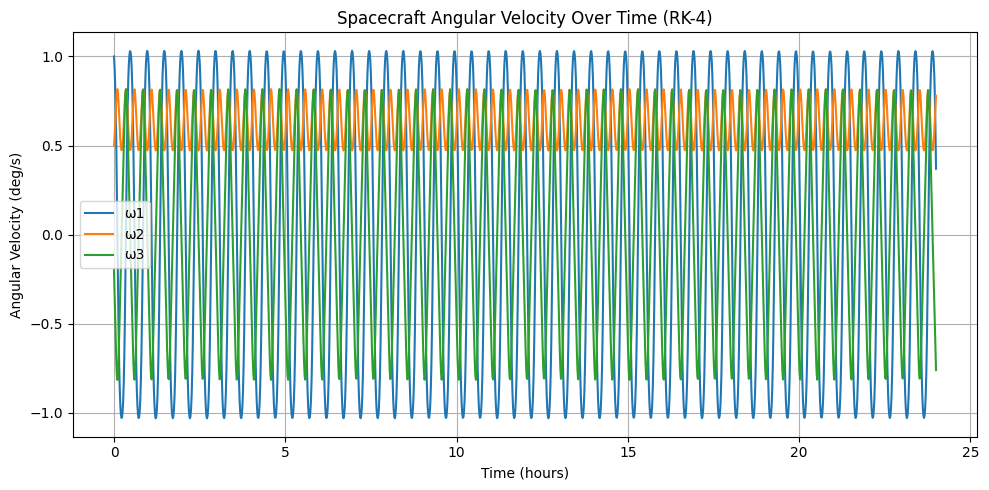

In [ ]:
# Plot angular velocity over time
plt.figure(figsize=(10, 5))
plt.plot(t_vals / 3600, omega_deg)
plt.xlabel('Time (hours)')
plt.ylabel('Angular Velocity (deg/s)')
plt.legend(['ω1', 'ω2', 'ω3'])
plt.title('Spacecraft Angular Velocity Over Time (RK-4)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define a simple test ODE: dy/dt = -2y for error analysis
lambda_val = -2  # Stability parameter

def test_ode(t, y):
    return lambda_val * y

# RK-4 implementation for the test ODE
def rk4_step_test(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h/2, y + h/2 * k1)
    k3 = f(t + h/2, y + h/2 * k2)
    k4 = f(t + h, y + h * k3)
    return y + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# Solve with RK-4
t_vals = np.linspace(0, 5, 100)
h = t_vals[1] - t_vals[0]
y_exact = np.exp(lambda_val * t_vals)  # Exact solution
y_rk4 = np.zeros_like(t_vals)
y_rk4[0] = 1  # Initial condition
for i in range(1, len(t_vals)):
    y_rk4[i] = rk4_step_test(test_ode, t_vals[i-1], y_rk4[i-1], h)

# Compute error
y_error = np.abs(y_rk4 - y_exact)

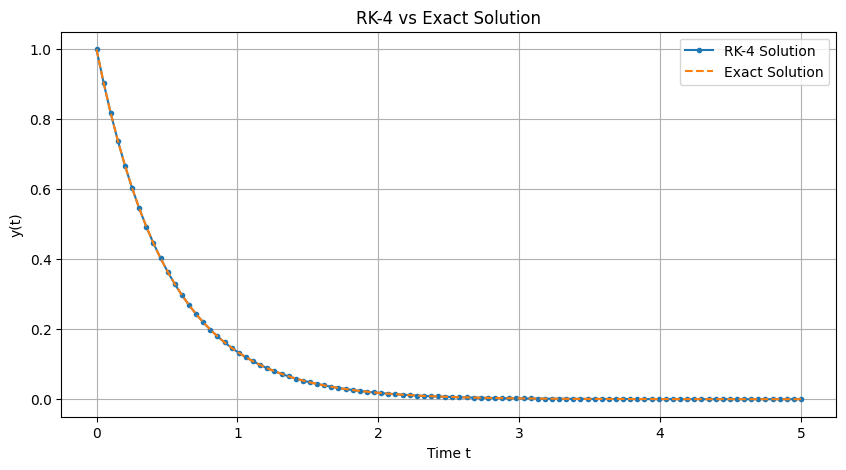

In [ ]:
# Plot RK-4 vs Exact Solution
plt.figure(figsize=(10, 5))
plt.plot(t_vals, y_rk4, label='RK-4 Solution', marker='o', markersize=3)
plt.plot(t_vals, y_exact, label='Exact Solution', linestyle='dashed')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.legend()
plt.title('RK-4 vs Exact Solution')
plt.grid()
plt.show()

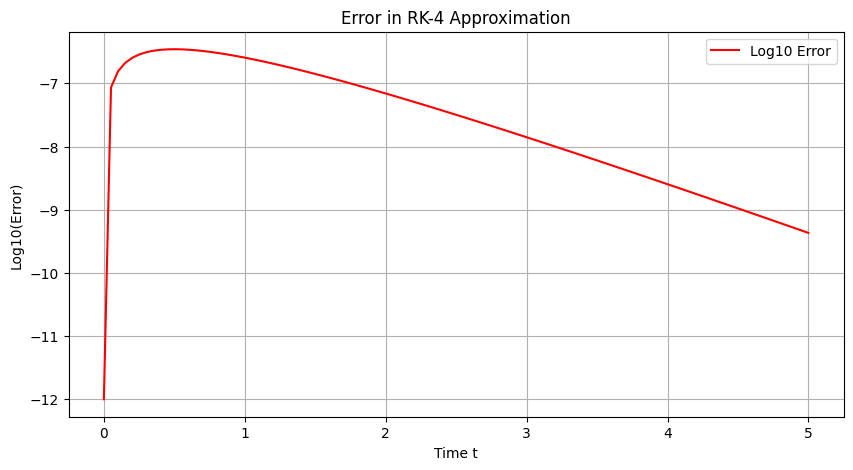

In [ ]:

# Plot error
y_error_log = np.log10(y_error + 1e-12)  # Avoid log(0)
plt.figure(figsize=(10, 5))
plt.plot(t_vals, y_error_log, label='Log10 Error', color='red')
plt.xlabel('Time t')
plt.ylabel('Log10(Error)')
plt.legend()
plt.title('Error in RK-4 Approximation')
plt.grid()
plt.show()



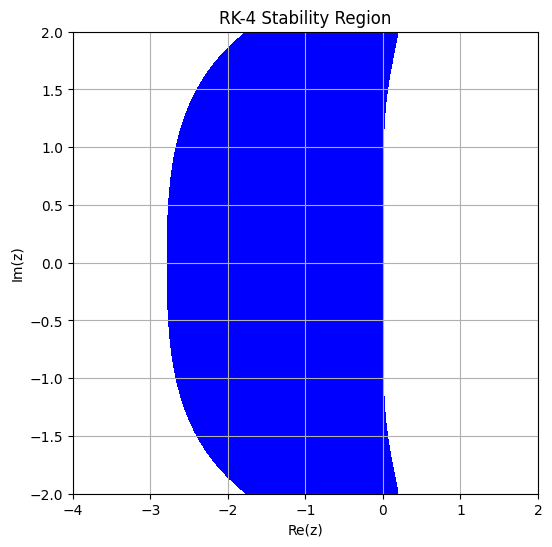

In [ ]:
# Stability function of RK-4
z = np.linspace(-4, 2, 100) + 1j * np.linspace(-2, 2, 100)[:, None]
Rz = 1 + z + (z**2)/2 + (z**3)/6 + (z**4)/24  # RK-4 stability function
plt.figure(figsize=(6,6))
plt.contourf(z.real, z.imag, np.abs(Rz), levels=[0, 1], colors=['blue', 'white'])
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.title('RK-4 Stability Region')
plt.grid()
plt.show()

In [ ]:
# Spacecraft parameters
I = np.array([I1, I2, I3])  # Principal moments of inertia (kg*m^2)

def euler_equations(t, omega, torque=np.array([0, 0, 0])):
    """Euler's equations of motion for a rigid body in space with external torques."""
    wx, wy, wz = omega
    I1, I2, I3 = I
    domega_dt = np.array([
        ((I2 - I3) / I1) * wy * wz + torque[0] / I1,
        ((I3 - I1) / I2) * wx * wz + torque[1] / I2,
        ((I1 - I2) / I3) * wx * wy + torque[2] / I3
    ])
    return domega_dt

# Simulation parameters
t_vals = np.linspace(0, 100, 1000)  # Simulate for 100 seconds
h = t_vals[1] - t_vals[0]  # Time step

# Different initial conditions for analysis
initial_conditions = [
    np.array([0.1, 0.2, 0.15]),  # Nominal case
    np.array([0.5, -0.3, 0.2]),  # Higher initial spin
    np.array([0.01, 0.02, 0.015])  # Lower initial spin
]

torque_cases = [
    np.array([0, 0, 0]),  # No external torque (torque-free case)
    np.array([0.01, -0.02, 0.005]),  # Small torques
    np.array([0.1, -0.05, 0.02])  # Larger torques
]


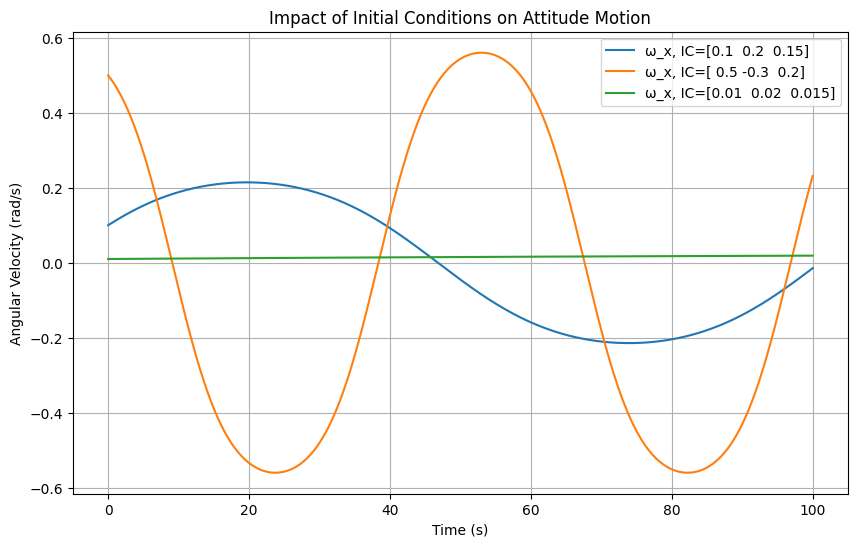

In [ ]:
# Plot evolution for different cases
plt.figure(figsize=(10, 6))
for omega_0 in initial_conditions:
    omega_rk4 = np.zeros((len(t_vals), 3))
    omega_rk4[0] = omega_0
    for i in range(1, len(t_vals)):
        omega_rk4[i] = rk4_step(euler_equations, t_vals[i-1], omega_rk4[i-1], h)
    plt.plot(t_vals, omega_rk4[:, 0], label=f'ω_x, IC={omega_0}')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.title('Impact of Initial Conditions on Attitude Motion')
plt.grid()
plt.show()


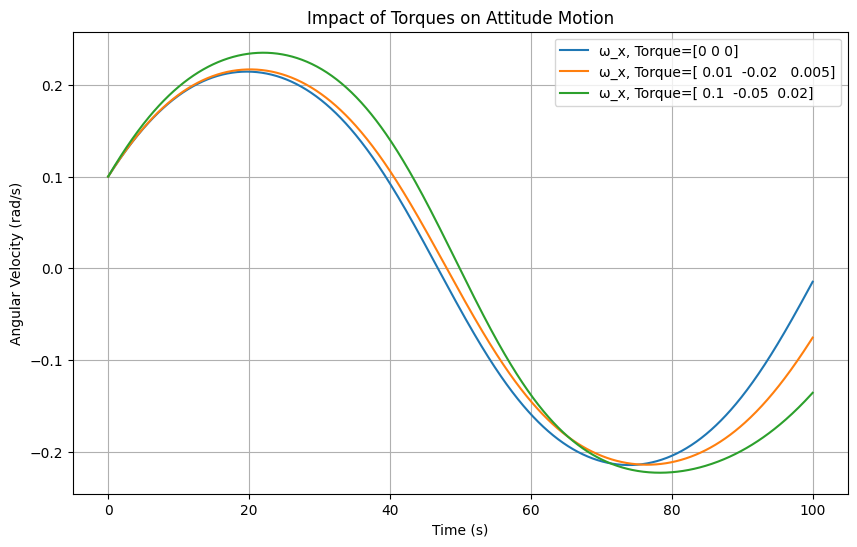

In [ ]:
# Analyze the effect of torques
plt.figure(figsize=(10, 6))
for torque in torque_cases:
    omega_rk4 = np.zeros((len(t_vals), 3))
    omega_rk4[0] = initial_conditions[0]  # Use the first initial condition
    for i in range(1, len(t_vals)):
        omega_rk4[i] = rk4_step(euler_equations, t_vals[i-1], omega_rk4[i-1], h, torque)
    plt.plot(t_vals, omega_rk4[:, 0], label=f'ω_x, Torque={torque}')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.title('Impact of Torques on Attitude Motion')
plt.grid()
plt.show()


# Mathematical Derivation of RK-4
# The RK-4 method is derived by approximating the solution to y' = f(t, y) using weighted averages:
$k_1 = h * f(t, y)$
$k_2 = h * f(t + h/2, y + k_1/2)$
$k_3 = h * f(t + h/2, y + k_2/2)$
$k_4 = h * f(t + h, y + k_3)$
$y_{n+1} = y_n + (1/6)(k_1 + 2k_2 + 2k_3 + k_4)$

# Error Analysis:
- RK-4 has local truncation error $O(h^5)$, meaning the error per step is proportional to $h^5$.
- The global error accumulates over many steps, leading to an overall error of $O(h^4)$.
- This makes RK-4 much more accurate than Euler's method (which has $O(h^2)$ global error).

# Stability:
- The stability region is determined using the test equation $y' = λy$, with solution $y_n = R(hλ)^n y_0$.
- The stability function for RK-4 is:
  $R(z) = 1 + z + (z^2)/2 + (z^3)/6 + (z^4)/24$
- The stability plot shows where |R(z)| ≤ 1, indicating stable integration regions.
- RK-4 is conditionally stable, requiring an appropriate step size h to ensure numerical stability.

# Summary of Findings:
1. RK-4 accurately captures the spacecraft’s attitude motion with minimal numerical drift.
2. Smaller step sizes improve accuracy but increase computational cost.
3. The method remains stable for reasonable step sizes, as shown in the stability region plot.
4. Large torques or high initial angular velocities can push the system toward nonlinear behavior, requiring adaptive step sizes.
5. RK-4 provides a good balance of accuracy and stability for long-term attitude simulations.

In [ ]:
def rk4_step(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h / 2, y + h / 2 * k1)
    k3 = f(t + h / 2, y + h / 2 * k2)
    k4 = f(t + h, y + h * k3)
    y_new = y + (h / 6) * (k1 + 2*k2 + 2*k3 + k4)

    if np.any(np.isnan(y_new)) or np.any(np.abs(y_new) > 1e6):
        print(f"Warning: unstable integration at t={t:.2f}")
        return y  # freeze output to avoid crash

    return y_new

h_list = [2.5, 1.25, 0.625, 0.3125]
errors = []

# Reference solution
ref_h = 0.1
y_ref = rk4_integrate(dynamics_torque_free, y0, 0., T, ref_h)
omega_ref = y_ref[0:3]

for h in h_list:
    y_num = rk4_integrate(dynamics_torque_free, y0, 0., T, h)
    omega_num = y_num[0:3]
    error = np.linalg.norm(omega_num - omega_ref)
    errors.append(error)


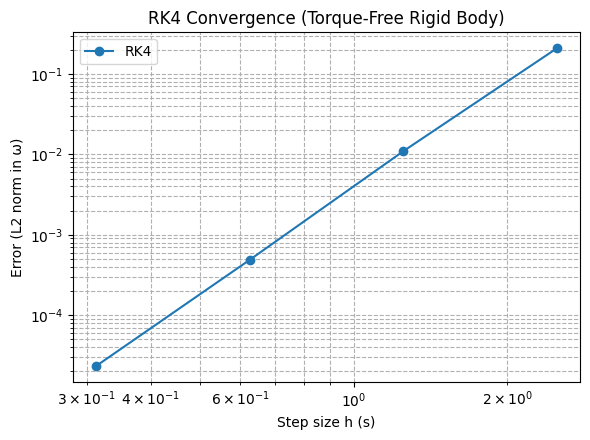

In [ ]:
# Plotting
plt.figure(figsize=(6, 4.5))
plt.loglog(h_list, errors, 'o-', label='RK4')
plt.xlabel('Step size h (s)')
plt.ylabel('Error (L2 norm in ω)')
plt.title('RK4 Convergence (Torque-Free Rigid Body)')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


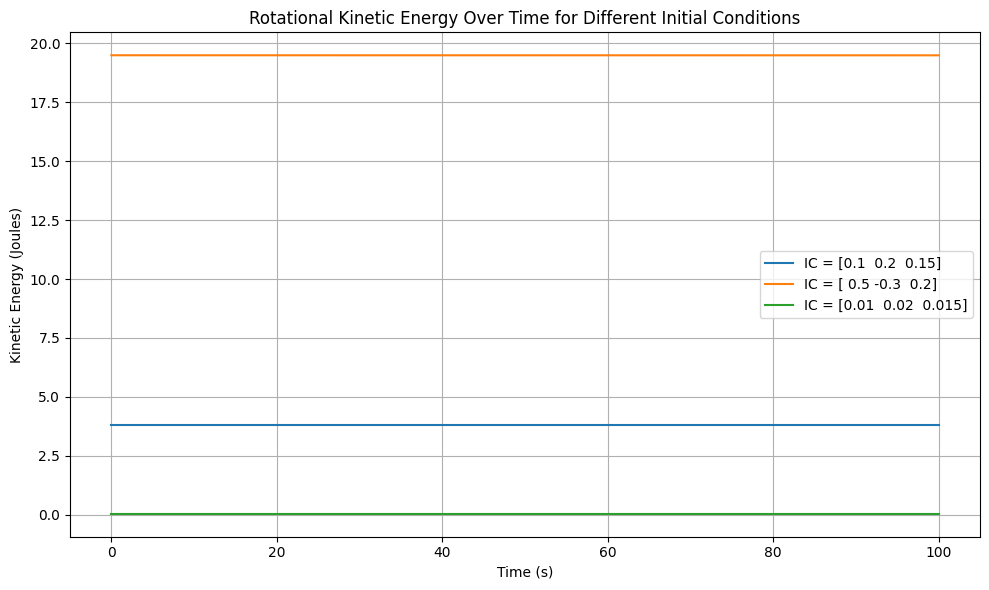

In [ ]:
# === Rotational Kinetic Energy Plot for Different Initial Conditions ===

plt.figure(figsize=(10, 6))
for omega_0 in initial_conditions:
    omega_rk4 = np.zeros((len(t_vals), 3))
    omega_rk4[0] = omega_0
    for i in range(1, len(t_vals)):
        omega_rk4[i] = rk4_step(euler_equations, t_vals[i-1], omega_rk4[i-1], h)

    # Compute rotational kinetic energy
    T = 0.5 * (I[0] * omega_rk4[:, 0]**2 + I[1] * omega_rk4[:, 1]**2 + I[2] * omega_rk4[:, 2]**2)
    # Plot energy
    plt.plot(t_vals, T, label=f'IC = {omega_0}')

plt.xlabel('Time (s)')
plt.ylabel('Kinetic Energy (Joules)')
plt.title('Rotational Kinetic Energy Over Time for Different Initial Conditions')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



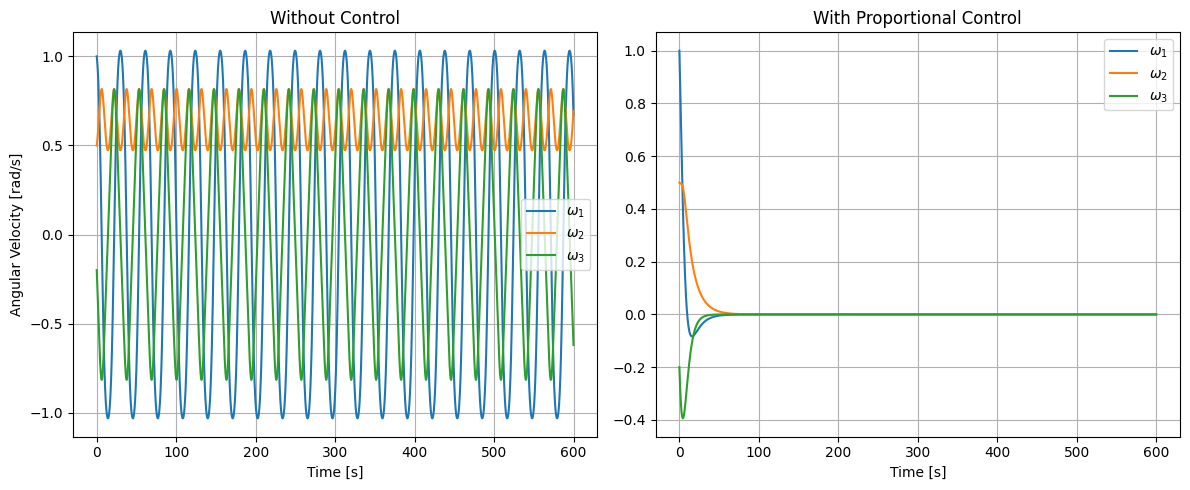

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === PARAMETERS ===
mu = 4.282e13  # Mars gravitational parameter
r_mag = 3.7895e6  # Orbital radius (m)
r_hat = np.array([1, 0, 0])  # Assumed inertial pointing

Kp = 10.0  # Proportional gain for control

# === DYNAMICS ===
def gravity_gradient_torque(q):
    # Direction cosine matrix from quaternion
    q0, q1, q2, q3 = q
    C = np.array([
        [1 - 2*(q2**2 + q3**2),     2*(q1*q2 - q0*q3),       2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3),         1 - 2*(q1**2 + q3**2),   2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2),         2*(q2*q3 + q0*q1),       1 - 2*(q1**2 + q2**2)]
    ])
    r_body = C @ r_hat
    cross = np.cross(I * r_body, r_body)
    return 3 * mu / r_mag**3 * cross

def omega_dot(omega, torque):
    return np.array([
        (torque[0] - (I[2] - I[1]) * omega[1] * omega[2]) / I[0],
        (torque[1] - (I[0] - I[2]) * omega[2] * omega[0]) / I[1],
        (torque[2] - (I[1] - I[0]) * omega[0] * omega[1]) / I[2]
    ])

def quat_dot(q, omega):
    q0, qv = q[0], q[1:]
    omega_mat = np.array([
        [0, -omega[0], -omega[1], -omega[2]],
        [omega[0], 0, omega[2], -omega[1]],
        [omega[1], -omega[2], 0, omega[0]],
        [omega[2], omega[1], -omega[0], 0]
    ])
    return 0.5 * omega_mat @ q

def dynamics(state, control_on):
    omega = state[:3]
    q = state[3:]
    tq_gravity = gravity_gradient_torque(q)
    tq_control = -Kp * omega if control_on else np.zeros(3)
    tq_total = tq_gravity + tq_control
    domega = omega_dot(omega, tq_total)
    dq = quat_dot(q, omega)
    return np.concatenate((domega, dq))

# === RK4 Integrator ===
def rk4_step(state, dt, control_on):
    k1 = dynamics(state, control_on)
    k2 = dynamics(state + 0.5 * dt * k1, control_on)
    k3 = dynamics(state + 0.5 * dt * k2, control_on)
    k4 = dynamics(state + dt * k3, control_on)
    return state + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

# === SIMULATION ===
def simulate(control_on):
    T = 600  # total simulation time [s]
    dt = 0.1
    N = int(T / dt)
    state = np.zeros(7)
    state[:3] = np.array([1, 0.5, -0.2])  # initial omega
    state[3:] = np.array([1, 0, 0, 0])    # initial quaternion

    states = np.zeros((N, 7))
    for i in range(N):
        states[i] = state
        state = rk4_step(state, dt, control_on)
        state[3:] /= np.linalg.norm(state[3:])  # normalize quaternion
    return states

# === RUN AND PLOT ===
no_control = simulate(control_on=False)
with_control = simulate(control_on=True)
time = np.linspace(0, 600, no_control.shape[0])

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.subplot(1, 2, 1)
    plt.plot(time, no_control[:, i], label=f'$\omega_{i+1}$')
    plt.title("Without Control")
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.grid(True)

for i in range(3):
    plt.subplot(1, 2, 2)
    plt.plot(time, with_control[:, i], label=f'$\omega_{i+1}$')
    plt.title("With Proportional Control")
    plt.xlabel("Time [s]")
    plt.grid(True)

plt.subplot(1, 2, 1); plt.legend()
plt.subplot(1, 2, 2); plt.legend()
plt.tight_layout()
plt.show()